# AnnoTree-diamond-jupyter
This notebook is part of the analysis of the TotalRNA   mRNA genes from Trinity. It was run by Curro 8/17/2023.

##### What's Diamond
DIAMOND is a sequence aligner for protein and translated DNA searches designed for high-performance analysis of big sequence data. 

##### Why AnnoTree?
The NCBI-nr database is not explicitly designed for microbiome analysis, and its increasing size makes it unwieldy and computationally expensive for this purpose. The AnnoTree protein database is only one-quarter the size of the entire NCBI-nr database and is explicitly designed for metagenomic analysis, so alignment-based pipelines should support it.
https://journals.asm.org/doi/10.1128/msystems.01408-21

##### Which input files?

1. Trinity fasta file
2. Abundance-filtered coun table

##### Which preprocessing?
We follow the same preprocessing as in CoMW. We filter by e-value, get the most significant contig, and the aggregate rows (we sum up all rows corresponding to different Trinity genes aligned to the same protein).  
https://academic.oup.com/gigascience/article/8/8/giz096/5541629?login=true

##### Which database files?

We are using three different files (all of them in /Databases/AnnoTree_mRNA/)
'annotree.dmnd' is a diamond database (a particular format obtained from a fasta file)
'megan-mapping-annotree-June-2021.db' is an SQLite file with mappings from the name of each protein to annotations. 
'ko00001.json' is a JSON file with the BRITE hierarchy annotation  for KEGG

## Analysis
First, check dependencies. Safe to ignore. 


In [1]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
bash --version | head -n 1

diamond version 2.1.6


1.5.2
3.7.1
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import closing
from enum import Enum

### Input files (edit this chunk)
Edit this chunk to match your input files

In [3]:
trinity_file = "../ncRNA_filtered_Trinity.fasta"
count_table = "../mRNA_soil_AbundanceFiltered.tsv"

In [4]:
## Sanity check: trinity and count table exit
assert os.path.exists(trinity_file), 'Trinity file does not exist'
assert os.path.exists(count_table), 'Count table does not exist'

### Output files (edit this chunk)
Edit this chunk to match your desired output files

In [5]:
outfile_matches = 'Annotree_matches_diamond.tsv'

### Database files
Don't edit this chunk

In [6]:
annotree_db = '/Databases/AnnoTree_mRNA/annotree'
mapping_db = '/Databases/AnnoTree_mRNA/megan-mapping-annotree-June-2021.db'
brite_json = '/Databases/AnnoTree_mRNA/ko00001.json'
assert os.path.exists(f"{annotree_db}.dmnd"), 'Annotree database does not exist'
assert os.path.exists(mapping_db), 'Mapping database does not exist'
assert os.path.exists(brite_json), 'Brite json file does not exist'

##### Run Diamond
When using Diamond, you should consider which sensitivity mode do you want to use. Default mode is designed for finding hits of >60% identity and it should take less than one hour to run. You might consider increase the sensitivity by editing the chunk below. 

In [7]:
%%bash -s "$annotree_db" "$trinity_file" "$outfile_matches"
if [ ! -f $3 ]; then
mkdir -p $(dirname $3)
diamond blastx -p 50 -d $1 -q $2 -o $3
fi
head $3


TRINITY_DN608301_c0_g1_i1	NZXX01000001_1_2024__GB_GCA_002702065_1	51.9	52	25	0	90	245	1	52	1.28e-08	59.3
TRINITY_DN608301_c0_g1_i1	RFIA01000215_1_25__GB_GCA_003695675_1	48.1	52	27	0	90	245	1	52	3.98e-07	55.1
TRINITY_DN608301_c0_g1_i1	DIYL01000026_1_74__GB_GCA_002428985_1	42.3	52	30	0	90	245	1	52	3.98e-07	55.1
TRINITY_DN608301_c0_g1_i1	QGUR01000124_1_9__GB_GCA_003242205_1	46.2	52	28	0	90	245	1	52	5.44e-07	54.7
TRINITY_DN608301_c0_g1_i1	NZ_BFCB01000004_1_223__RS_GCF_003569045_1	44.2	52	29	0	90	245	1	52	9.07e-06	51.2
TRINITY_DN608301_c0_g1_i1	PABP01000021_1_342__GB_GCA_002699585_1	42.3	52	30	0	90	245	39	90	9.14e-06	51.2
TRINITY_DN608301_c0_g1_i1	RFHA01000407_1_2__GB_GCA_003696565_1	38.5	52	32	0	90	245	1	52	1.24e-05	50.8
TRINITY_DN608301_c0_g1_i1	DEHQ01000256_1_30__GB_GCA_002352035_1	43.1	51	29	0	90	242	1	51	5.93e-05	48.9
TRINITY_DN608279_c0_g1_i1	NZ_CP011280_1_764__RS_GCF_000973085_1	100	125	0	0	3	377	95	219	1.35e-74	236
TRINITY_DN608279_c0_g1_i1	NZ_LOQF01000002_1_112__RS_GCF_001517935_1	

##### Preprocessing Diamond matches
We read the file into a pandas table:

In [8]:
diamond = pd.read_csv(
    outfile_matches,delimiter='\t',comment='#', header=None,
    names= ['Query_id', 'Subject_id', '%_identity', 'alignment_length', 
             'mismatches','gap_openings','q_start', 'q_end',
             's_start',
              's_end', 'e-value', 'score'
            ]
)
diamond

,Query_id,Subject_id,%_identity,alignment_length,mismatches,gap_openings,q_start,q_end,s_start,s_end,e-value,score
0,TRINITY_DN608301_c0_g1_i1,NZXX01000001_1_2024__GB_GCA_002702065_1,51.9,52,25,0,90,245,1,52,1.280000e-08,59.3
1,TRINITY_DN608301_c0_g1_i1,RFIA01000215_1_25__GB_GCA_003695675_1,48.1,52,27,0,90,245,1,52,3.980000e-07,55.1
2,TRINITY_DN608301_c0_g1_i1,DIYL01000026_1_74__GB_GCA_002428985_1,42.3,52,30,0,90,245,1,52,3.980000e-07,55.1
3,TRINITY_DN608301_c0_g1_i1,QGUR01000124_1_9__GB_GCA_003242205_1,46.2,52,28,0,90,245,1,52,5.440000e-07,54.7
4,TRINITY_DN608301_c0_g1_i1,NZ_BFCB01000004_1_223__RS_GCF_003569045_1,44.2,52,29,0,90,245,1,52,9.070000e-06,51.2
...,...,...,...,...,...,...,...,...,...,...,...,...
13624708,TRINITY_DN264_c0_g1_i19,PMIE01000119_1_14__GB_GCA_003156975_1,69.8,96,28,1,362,75,21,115,7.970000e-33,123.0
13624709,TRINITY_DN264_c0_g1_i19,PNAZ01000088_1_25__GB_GCA_003169655_1,67.8,87,28,0,323,63,204,290,3.490000e-28,112.0
13624710,TRINITY_DN264_c0_g1_i19,PNAP01000042_1_57__GB_GCA_003169735_1,85.7,35,5,0,257,361,2,36,3.570000e-12,66.6
13624711,TRINITY_DN264_c0_g1_i19,PMYK01000026_1_35__GB_GCA_003171255_1,80.0,30,6,0,272,361,4,33,6.470000e-05,50.4


We also add the count table into a Pandas data frame:

In [9]:
counts = pd.read_csv(
    count_table, sep = "\t", comment='#'
).set_index('ContigID')
counts

,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,X3,t1.6,X2,t4.42,t2.28,t1.4,t1.1,t1.5,X5,t2.29
ContigID,,,,,,,,,,,,,,,,,,,,,
TRINITY_DN3994_c0_g1_i1,0,0,7,0,0,7,0,0,9,0,...,8,0,4,0,0,0,0,0,9,0
TRINITY_DN270143_c0_g1_i1,3,5,0,4,0,3,4,0,11,0,...,4,0,4,0,0,0,10,0,7,0
TRINITY_DN118327_c0_g1_i9,1,0,6,2,2,0,6,4,0,0,...,7,5,8,0,0,5,1,2,2,0
TRINITY_DN11451_c1_g1_i14,0,1,11,0,1,9,0,0,1,0,...,6,5,8,0,3,13,1,4,11,1
TRINITY_DN13783_c0_g1_i8,0,4,3,1,4,7,2,5,10,7,...,1,0,3,0,0,0,0,2,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRINITY_DN3655_c0_g1_i21,10,3,15,21,10,10,10,26,8,36,...,4,12,8,18,23,18,4,16,18,14
TRINITY_DN4235_c0_g1_i20,2,3,5,3,0,10,6,1,23,5,...,6,0,4,0,0,0,10,1,6,2
TRINITY_DN58984_c0_g1_i2,1,10,10,0,0,0,2,1,0,1,...,0,0,0,0,0,0,14,0,1,0


##### Most significant hit per contig
First, we are going to drop unsignificant hits by E-value. We are setting a 0.0001 threshold.


Text(0.5, 1.0, 'E-value distribution before filtering')

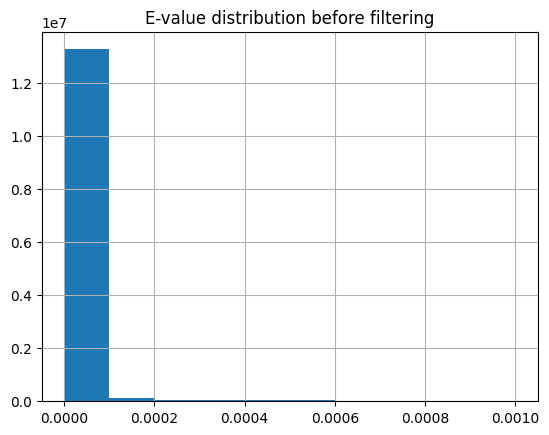

In [10]:
diamond.hist("e-value")
plt.title("E-value distribution before filtering")

Text(0.5, 1.0, 'E-value distribution after filtering (with threshold 0.0001)')

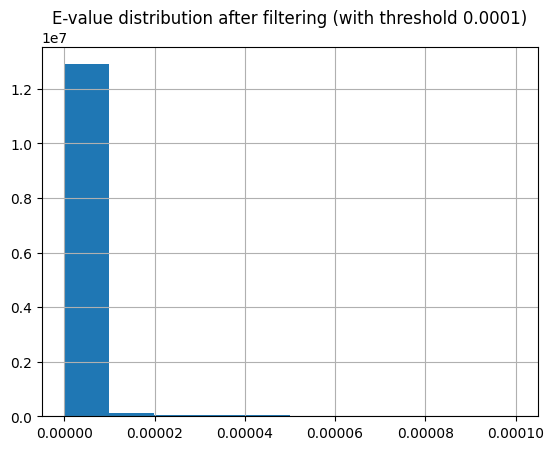

In [11]:
evalue_threshold = 0.0001
diamond = diamond.loc[diamond['e-value'] < evalue_threshold] 
diamond.hist("e-value")
plt.title(f"E-value distribution after filtering (with threshold {evalue_threshold})")


Now, we will sort rows per e-value and score and get the most significant hit per each ContigId.

Text(0.5, 1.0, 'Number of hits per contig before preprocessing')

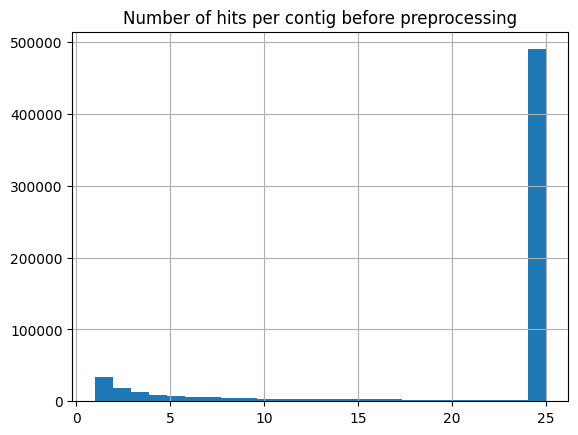

In [12]:
diamond.pivot_table(columns=['Query_id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig before preprocessing")


Number of rows. Before: 159105684. After: 6972746


Text(0.5, 1.0, 'Number of hits per contig after preprocessing')

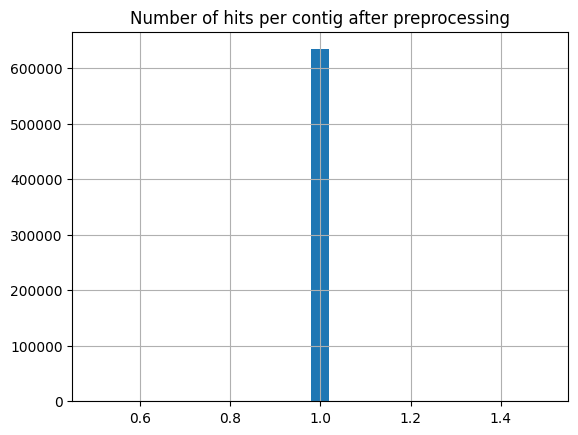

In [13]:
before = diamond.size
diamond = diamond.sort_values(
        by=['e-value', 'score'], ascending=[True, False]
        ).drop_duplicates(
    'Query_id', keep='first'
).set_index('Query_id')
after = diamond.size

print(f"Number of rows. Before: {before}. After: {after}")

diamond.pivot_table(columns=['Query_id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig after preprocessing")

#####  Inspect % identity and aligment length

Text(0.5, 1.0, 'Alignment length distribution after preprocessing')

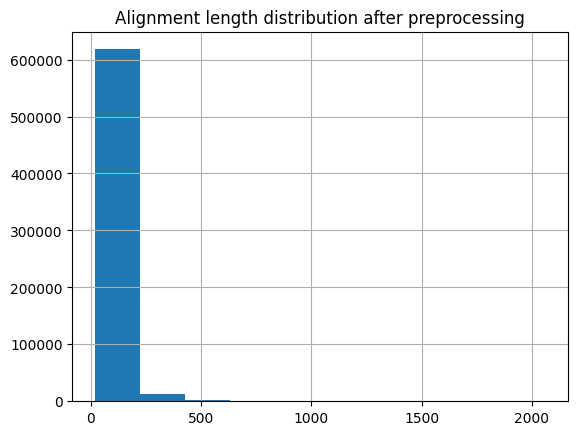

In [14]:
diamond.hist("alignment_length")
plt.title("Alignment length distribution after preprocessing")


Text(0, 0.5, 'Mistmatches')

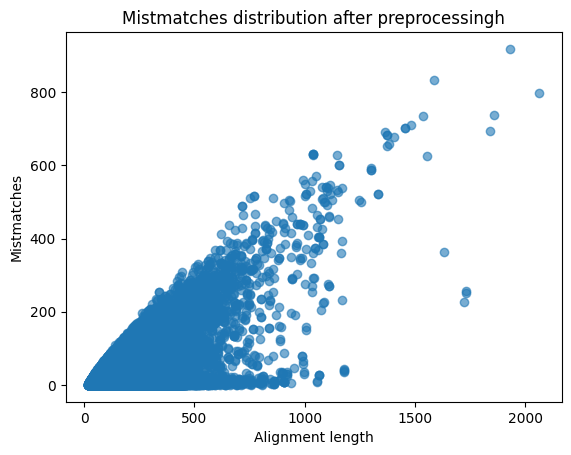

In [15]:
plt.scatter(diamond.alignment_length,diamond.mismatches,alpha=0.6)
plt.title('Mistmatches distribution after preprocessingh')
plt.xlabel('Alignment length')
plt.ylabel('Mistmatches')

Text(0.5, 1.0, 'Percentage of identity distribution after preprocessing')

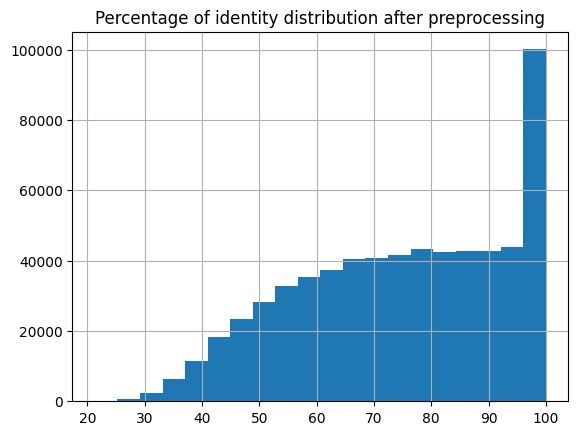

In [16]:
diamond.hist("%_identity", bins = 20)
plt.title("Percentage of identity distribution after preprocessing")


You may want to filter by % identity (for example, keep everything above 50%). 

##### Link information form diamond matches and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header

In [17]:
map_table = diamond[["Subject_id"]]
map_table

,Subject_id
Query_id,
TRINITY_DN5_c0_g1_i14,NZ_AFPU01000001_1_1603__RS_GCF_000220175_1
TRINITY_DN5_c0_g1_i26,NZ_AFPU01000001_1_1603__RS_GCF_000220175_1
TRINITY_DN5_c0_g1_i7,NZ_AFPU01000001_1_1603__RS_GCF_000220175_1
TRINITY_DN1554_c3_g1_i97,NZ_LZSE01000010_1_2__RS_GCF_001665295_1
TRINITY_DN1554_c3_g1_i89,NZ_LZSE01000010_1_2__RS_GCF_001665295_1
...,...
TRINITY_DN703599_c0_g1_i1,SYMT01000584_1_1__GB_GCA_005805375_1
TRINITY_DN1028619_c0_g1_i1,DGOV01000117_1_1__GB_GCA_002390205_1
TRINITY_DN918507_c0_g1_i1,BEIR01000025_1_5__GB_GCA_002898855_1


Now, we will merge both files by their column in common (ContigID and Subject id).

In [18]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(drop=True)
df


,Subject_id,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,...,X3,t1.6,X2,t4.42,t2.28,t1.4,t1.1,t1.5,X5,t2.29
0,NZ_AFPU01000001_1_1603__RS_GCF_000220175_1,1046,1824,184,2530,1324,180,2648,1810,185,...,195,328,162,3082,1500,329,1066,367,229,2228
1,NZ_AFPU01000001_1_1603__RS_GCF_000220175_1,1181,2048,203,2712,1396,185,2770,1845,200,...,204,327,203,3238,1577,340,1185,429,276,2364
2,NZ_AFPU01000001_1_1603__RS_GCF_000220175_1,1086,1823,203,2590,1348,131,2552,1733,212,...,172,369,180,2912,1441,397,1051,373,206,2183
3,NZ_LZSE01000010_1_2__RS_GCF_001665295_1,48,1059,752,28,0,31,396,292,40,...,59,14,298,3,3,3,725,0,304,3
4,NZ_LZSE01000010_1_2__RS_GCF_001665295_1,42,1114,830,28,0,33,451,331,54,...,48,7,239,5,1,3,711,1,319,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52631,NZ_RAPG01000054_1_1__RS_GCF_005239165_1,0,22,8,0,0,0,3,4,0,...,2,0,2,2,0,1,12,0,4,0
52632,NZ_RAPG01000054_1_1__RS_GCF_005239165_1,0,20,16,0,0,0,8,7,0,...,2,0,12,0,0,0,22,0,4,0
52633,DNCG01000012_1_4__GB_GCA_003491635_1,27,23,21,18,4,29,65,11,53,...,58,0,18,9,9,3,23,2,47,8
52634,NZ_SWFJ01000027_1_1__RS_GCF_005144795_1,0,8,6,0,0,0,7,1,0,...,0,0,2,0,0,1,8,0,4,0


##### Aggregate table
Now, we are going to aggregate the rows by grouping them by "Subject id" (notice the difference in rows between the previous table and the following):

In [19]:
df = df.groupby('Subject_id').sum(numeric_only = True)
df


,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,X3,t1.6,X2,t4.42,t2.28,t1.4,t1.1,t1.5,X5,t2.29
Subject_id,,,,,,,,,,,,,,,,,,,,,
AASF01000118_1_2__GB_GCA_000168735_1,2,51,37,1,0,2,20,7,3,40,...,6,1,6,1,0,0,29,0,6,0
AASF01001891_1_3__GB_GCA_000168735_1,0,7,10,0,6,8,5,0,2,0,...,3,2,4,4,4,4,0,7,4,2
ABYL01000016_1_55__GB_GCA_000173575_1,0,6,3,0,0,2,2,0,0,18,...,0,0,1,0,0,2,0,0,2,0
AE009439_1_1046__GB_GCA_000007185_1,4,0,2,0,4,0,0,0,6,0,...,0,8,0,2,8,4,2,8,0,0
AGAU01000083_1_102__GB_GCA_000224765_2,126,108,74,139,147,291,284,49,198,9,...,224,98,106,215,145,104,93,140,391,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VJOU01000316_1_1__GB_GCA_007050995_1,0,0,0,0,0,0,0,0,0,0,...,0,6,2,2,8,44,0,8,0,6
VKDC01000020_1_115__GB_GCA_007097395_1,2,0,17,0,0,2,0,0,2,0,...,2,2,14,1,0,0,0,0,0,0
VKKU01000002_1_652__GB_GCA_007280415_1,561,202,112,306,506,224,363,107,200,8,...,334,934,130,413,515,998,244,1145,307,512


##### Annotating the OTU
Now, we have to annotate the previous table. 

We will use the SQLite file of AnnoTree. You can safely ignore this next chunk if you are still getting familiar with SQL. 

We are annotating only with the NCBI tax id and the KEGG and Interpro Identifier.

In [20]:
conn = sqlite3.connect(mapping_db)
VALID_COLUMNS = ('Accession', 'Taxonomy', 'GTDB', 'EGGNOG', 'INTERPRO2GO','SEED', 'EC', 'KEGG', 'PFAM', 'TIGRFAM')
MapColumn = Enum('MapColumn', [(a, a) for a in VALID_COLUMNS], type=str)

def get_column(conn: sqlite3.Connection, column: MapColumn, acc: str)-> int:
    with closing(conn.cursor()) as cursor:
        cursor.execute(f"SELECT {column.value} FROM mappings WHERE Accession = ?", (acc,))
        return cursor.fetchone()[0]

def get_NCBI_taxonomy(conn: sqlite3.Connection, acc: str)-> int:
    return get_column(conn, MapColumn.Taxonomy, acc)

def get_KEGG_KO(conn: sqlite3.Connection, acc: str)-> int:
    val = get_column(conn, MapColumn.KEGG, acc)
    if val:
        return f"K{str(val).zfill(5)}"
    return ""

def get_INTERPRO2GO(conn: sqlite3.Connection, acc: str) -> int:
    val = get_column(conn, MapColumn.INTERPRO2GO, acc)
    if val:
        return f"IPR{str(val).zfill(6)}"
    return ""    

Now we add new columns:

In [21]:
df['NCBI_TaxID'] = [get_NCBI_taxonomy(conn, acc) for acc in df.index]
df['KEGG'] = [get_KEGG_KO(conn, acc) for acc in df.index]
df['INTERPRO2GO'] = [get_INTERPRO2GO(conn, acc) for acc in df.index]
df

,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,t4.42,t2.28,t1.4,t1.1,t1.5,X5,t2.29,NCBI_TaxID,KEGG,INTERPRO2GO
Subject_id,,,,,,,,,,,,,,,,,,,,,
AASF01000118_1_2__GB_GCA_000168735_1,2,51,37,1,0,2,20,7,3,40,...,1,0,0,29,0,6,0,394104,,
AASF01001891_1_3__GB_GCA_000168735_1,0,7,10,0,6,8,5,0,2,0,...,4,4,4,0,7,4,2,394104,,
ABYL01000016_1_55__GB_GCA_000173575_1,0,6,3,0,0,2,2,0,0,18,...,0,0,2,0,0,2,0,516466,K03599,IPR040079
AE009439_1_1046__GB_GCA_000007185_1,4,0,2,0,4,0,0,0,6,0,...,2,8,4,2,8,0,0,190192,K02965,IPR002583
AGAU01000083_1_102__GB_GCA_000224765_2,126,108,74,139,147,291,284,49,198,9,...,215,145,104,93,140,391,156,1073573,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VJOU01000316_1_1__GB_GCA_007050995_1,0,0,0,0,0,0,0,0,0,0,...,2,8,44,0,8,0,6,2518983,,
VKDC01000020_1_115__GB_GCA_007097395_1,2,0,17,0,0,2,0,0,2,0,...,1,0,0,0,0,0,0,2594266,K02931,
VKKU01000002_1_652__GB_GCA_007280415_1,561,202,112,306,506,224,363,107,200,8,...,413,515,998,244,1145,307,512,1343899,,


#### Taxonomic annotation of mRNA

Most AnnoTree entries have a NCBI taxonomy identifier (except those with NCBI_TaxID == 0). However, keep in mind that we are using mRNA and that, while a relatively high % identity might be enough to annotate a protein, it might not be enough asign a taxonomic identifier. For that case, using MEGAN can be a better option. 

We are going to be conservative, exclude entries with low % of identity and create an abundance table with the taxonomic annotation. It's interesting to know from which organisms we are "taking" the functional annotations. Is there any overrepresented specie?

In [43]:
taxa_tbl = diamond[diamond['%_identity'] >= 99]["Subject_id"]
taxa_df = pd.merge(taxa_tbl, counts, left_index=True, right_index=True).reset_index(drop=True).groupby('Subject_id').sum(numeric_only = True)
taxa_df['NCBI_TaxID'] = [get_NCBI_taxonomy(conn, acc) for acc in taxa_df.index]
taxa_df

,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,t1.6,X2,t4.42,t2.28,t1.4,t1.1,t1.5,X5,t2.29,NCBI_TaxID
Subject_id,,,,,,,,,,,,,,,,,,,,,
ABYL01000016_1_55__GB_GCA_000173575_1,0,6,3,0,0,2,2,0,0,18,...,0,1,0,0,2,0,0,2,0,516466
AP014718_1_1212__GB_GCA_002370555_1,2,0,5,1,3,10,2,4,4,0,...,0,3,5,5,9,0,2,14,4,1588021
AP014718_1_1351__GB_GCA_002370555_1,0,0,0,0,12,0,0,0,0,0,...,0,0,2,7,2,0,2,0,6,1588021
AP014718_1_1763__GB_GCA_002370555_1,0,0,2,4,6,5,0,4,2,0,...,0,4,0,2,0,0,2,7,4,1588021
AP014718_1_2437__GB_GCA_002370555_1,2,0,0,0,14,0,0,0,0,0,...,4,0,10,8,7,0,6,0,16,1588021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UQDH01000020_1_53__GB_GCA_900539805_1,0,5,3,2,0,0,3,1,8,3,...,0,6,0,0,0,6,0,0,0,253813
UQDH01000044_1_21__GB_GCA_900539805_1,0,2,0,0,0,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,253813
VBAR01000006_1_124__GB_GCA_005882315_1,0,2,4,0,0,4,0,0,7,0,...,2,5,0,2,0,0,1,6,3,1898104


You can search the corresponding taxa using NCBI. For example, let's check the first five more abundant OTU:

In [44]:
for tax in taxa_df['NCBI_TaxID'].value_counts().index[:5]:
    print(f"https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id={tax}")


https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=1747
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=294
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=1144336
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=1736395
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=1736593


For example, if you suspect you have mRNA from the host, you can check the number of entries from the host. Let's check number of entries from human (it should be zero, because it's not included in AnnoTree database). 

In [45]:
HUMAN_TAXID = 9606
sum(taxa_df['NCBI_TaxID'] == HUMAN_TAXID)

0

Finally, we are going to add different taxonomic ranks. First, we define a few functions. 

In [46]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()

def get_lineage(taxid):
    """Get dictionary with rank as keys and name as values
    >>> get_lineage(49992).get('species')
    'Thymus vulgaris'
    >>> get_lineage(2)
    {'no rank': 'cellular organisms', 'superkingdom': 'Bacteria'}
    >>> get_lineage(0)
    {}
    """
    if taxid <= 0:
        return {}
    try:
        lineage = ncbi.get_lineage(taxid)
        ranks = ncbi.get_rank(lineage)
        names = ncbi.translate_to_names(lineage)
        return {ranks[k]: elm for k, elm  in zip(lineage, names)}
    except ValueError:
        return {}
def get_taxonomy_row(taxid):
    """
    Parse taxa into greengenes-like format
    >>> get_taxonomy_row(49992)
    'k__Viridiplantae;p__Streptophyta;c__Magnoliopsida;o__Lamiales;f__Lamiaceae;g__Thymus;s__Thymus vulgaris'
    """
    lineage = get_lineage(taxid)
    ranks = {
        'kingdom': 'k__', 'phylum':'p__', 'class': 'c__',
        'order':'o__', 'family':'f__', 'genus':'g__', 'species':'s__'
        }
    for rank in ranks:
        ranks[rank] += lineage.get(rank, '')
    return ";".join(ranks.values())

def get_taxonomy_row2(taxid):
    """
    Parse taxa separated with semicolon
    >>> get_taxonomy_row2(49992)
    'Viridiplantae;Streptophyta;Magnoliopsida;Lamiales;Lamiaceae;Thymus;Thymus vulgaris'
    """
    lineage = get_lineage(taxid)
    ranks = {rank:'' for rank in (
        'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'
    )}        
    for rank in ranks:
        ranks[rank] += lineage.get(rank, 'X')
    return ";".join(ranks.values())
import doctest
doctest.testmod()


TestResults(failed=0, attempted=5)

In [47]:
#[get_taxonomy_row(taxid) for taxid in taxa_df['NCBI_TaxID'][1:5]]
taxa_df = taxa_df.reset_index(drop=True).groupby('NCBI_TaxID').sum(numeric_only = True)
taxa_df['Taxonomy'] = [get_taxonomy_row(int(taxid)) for taxid in taxa_df.index]
taxa_df

/home/curro/.conda/envs/curro_dev/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 80870 was translated into 80867
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/curro/.conda/envs/curro_dev/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 143813 was translated into 2684212
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/curro/.conda/envs/curro_dev/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 665135 was translated into 2961896
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/curro/.conda/envs/curro_dev/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1349793 was translated into 1281780
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/curro/.conda/envs/curro_dev/lib/pyth

,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,t1.6,X2,t4.42,t2.28,t1.4,t1.1,t1.5,X5,t2.29,Taxonomy
NCBI_TaxID,,,,,,,,,,,,,,,,,,,,,
294,2364,2450,4064,3845,3420,4832,1453,3769,3262,3551,...,1118,3968,3419,3037,1475,850,1184,3968,2722,k__;p__Pseudomonadota;c__Gammaproteobacteria;o...
303,92,57,29,138,84,28,48,140,18,117,...,17,65,89,84,34,26,41,23,61,k__;p__Pseudomonadota;c__Gammaproteobacteria;o...
305,0,4,0,0,0,0,2,0,2,28,...,0,0,0,0,0,1,0,0,0,k__;p__Pseudomonadota;c__Betaproteobacteria;o_...
329,1,9,0,0,0,2,2,10,14,85,...,0,0,0,0,0,8,1,2,2,k__;p__Pseudomonadota;c__Betaproteobacteria;o_...
333,2,6,5,8,12,3,2,17,8,26,...,6,4,4,4,1,0,0,3,8,k__;p__Pseudomonadota;c__Gammaproteobacteria;o...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570926,0,90,41,4,3,51,24,8,96,43,...,0,14,1,4,1,55,0,46,2,k__;p__Bacteroidota;c__Bacteroidia;o__Marinila...
2575374,2,10,32,31,65,19,31,51,11,17,...,3,39,33,57,6,1,1,26,46,k__;p__Actinomycetota;c__Actinomycetes;o__Micr...
2590775,2,3,12,5,36,12,15,6,9,3,...,1,12,12,26,0,6,2,4,11,k__;p__Actinomycetota;c__Actinomycetes;o__Micr...


In [52]:
taxa_df.to_csv('AnnoTree_matches_annotated_Taxonomy.tsv', sep='\t', index=False)

### Functional annotation

Now, we are going to annotate the OTU with the KEGG and Interpro identifiers. Let's check how many non-annotated entries do we have:

In [48]:
print(f"There are {df.shape[0]} rows in the dataframe")
print(f"There are {(df['KEGG'] == '').sum()} rows with no KEGG identifier")
print(f"There are {(df['INTERPRO2GO'] == '').sum()} rows with no INTERPRO2GO identifier")


There are 20581 rows in the dataframe
There are 9884 rows with no KEGG identifier
There are 18414 rows with no INTERPRO2GO identifier


##### Adding BRITE high-level annotations
Now, we can use KEGG BRITE to add high-level annotations to this table. It's not pretty code, but it works:



In [49]:
import json
with open(brite_json, 'r') as json_file:
    # Read the contents of the file
    json_data = json_file.read()
    # Parse the JSON data
    brite = json.loads(json_data)
def get_brite(kos, include = [], ) -> dict[str: tuple[str]]:
    annotations = dict()
    for LevelA in brite['children']:
            if LevelA['name'] not in include:
                continue
            for LevelB in LevelA.get('children', []):
                for LevelC in LevelB.get('children', []):
                    for LevelD in LevelC.get('children', []):
                        name = LevelD['name'].split()[0]
                        if name in kos:
                            description = LevelD['name'].split(';')[1].strip()
                            new_annotation = (LevelA['name'], LevelB['name'], LevelC['name'], description)
                            if name in annotations:
                                annotations[name].append(new_annotation)
                            annotations[name] = [new_annotation]
    return annotations

Now, we get some annotations. We have to decide which annotations to use. Those are the ones available in the BRITE hierarchy:

In [50]:
[y['name'] for y in brite['children']]

['09100 Metabolism',
 '09120 Genetic Information Processing',
 '09130 Environmental Information Processing',
 '09140 Cellular Processes',
 '09150 Organismal Systems',
 '09160 Human Diseases',
 '09180 Brite Hierarchies',
 '09190 Not Included in Pathway or Brite']

We are going to use annotate with both Brite and Metabolism.

In [51]:
annotations = get_brite(df.KEGG.to_list(), include = '09180 Brite Hierarchies') 

And we add them to the DataFrame

In [30]:
df['Level1'] = [",".join(x[1] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Level2'] = [",".join(x[2] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Level3'] = [",".join(x[3] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df

,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,t1.1,t1.5,X5,t2.29,NCBI_TaxID,KEGG,INTERPRO2GO,Level1,Level2,Level3
Subject_id,,,,,,,,,,,,,,,,,,,,,
AASF01000118_1_2__GB_GCA_000168735_1,2,51,37,1,0,2,20,7,3,40,...,29,0,6,0,394104,,,,,
AASF01001891_1_3__GB_GCA_000168735_1,0,7,10,0,6,8,5,0,2,0,...,0,7,4,2,394104,,,,,
ABYL01000016_1_55__GB_GCA_000173575_1,0,6,3,0,0,2,2,0,0,18,...,0,0,2,0,516466,K03599,IPR040079,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],stringent starvation protein A
AE009439_1_1046__GB_GCA_000007185_1,4,0,2,0,4,0,0,0,6,0,...,2,8,0,0,190192,K02965,IPR002583,09182 Protein families: genetic information pr...,03011 Ribosome [BR:ko03011],small subunit ribosomal protein S19
AGAU01000083_1_102__GB_GCA_000224765_2,126,108,74,139,147,291,284,49,198,9,...,93,140,391,156,1073573,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VJOU01000316_1_1__GB_GCA_007050995_1,0,0,0,0,0,0,0,0,0,0,...,0,8,0,6,2518983,,,,,
VKDC01000020_1_115__GB_GCA_007097395_1,2,0,17,0,0,2,0,0,2,0,...,0,0,0,0,2594266,K02931,,09182 Protein families: genetic information pr...,03011 Ribosome [BR:ko03011],large subunit ribosomal protein L5
VKKU01000002_1_652__GB_GCA_007280415_1,561,202,112,306,506,224,363,107,200,8,...,244,1145,307,512,1343899,,,,,


Let's show a few annotated rows: 

In [31]:
df[df['Level1'] != '']

,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,t1.1,t1.5,X5,t2.29,NCBI_TaxID,KEGG,INTERPRO2GO,Level1,Level2,Level3
Subject_id,,,,,,,,,,,,,,,,,,,,,
ABYL01000016_1_55__GB_GCA_000173575_1,0,6,3,0,0,2,2,0,0,18,...,0,0,2,0,516466,K03599,IPR040079,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],stringent starvation protein A
AE009439_1_1046__GB_GCA_000007185_1,4,0,2,0,4,0,0,0,6,0,...,2,8,0,0,190192,K02965,IPR002583,09182 Protein families: genetic information pr...,03011 Ribosome [BR:ko03011],small subunit ribosomal protein S19
AP014718_1_1351__GB_GCA_002370555_1,0,0,0,0,12,0,0,0,0,0,...,0,2,0,6,1588021,K11954,,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],neutral amino acid transport system substrate-...
AP014718_1_1695__GB_GCA_002370555_1,0,0,0,1,6,4,0,1,0,0,...,0,1,0,12,1588021,K02956,IPR005290,09182 Protein families: genetic information pr...,03011 Ribosome [BR:ko03011],small subunit ribosomal protein S15
AP014718_1_1763__GB_GCA_002370555_1,0,0,2,4,6,5,0,4,2,0,...,0,2,7,4,1588021,K02916,IPR021137,09182 Protein families: genetic information pr...,03011 Ribosome [BR:ko03011],large subunit ribosomal protein L35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VJOU01000082_1_1__GB_GCA_007050995_1,148,224,71,86,204,12,28,71,15,46,...,178,408,13,173,2518983,K05692,,09183 Protein families: signaling and cellular...,04147 Exosome [BR:ko04147],actin beta/gamma 1
VJOU01000167_1_1__GB_GCA_007050995_1,9,15,0,0,1,0,0,0,0,0,...,16,0,0,0,2518983,K08770,,09182 Protein families: genetic information pr...,04121 Ubiquitin system [BR:ko04121],ubiquitin C
VJOU01000219_1_1__GB_GCA_007050995_1,4,2,0,2,6,4,0,0,0,14,...,0,24,0,7,2518983,K02865,,09182 Protein families: genetic information pr...,03011 Ribosome [BR:ko03011],large subunit ribosomal protein L10Ae


In [32]:
df.index.name = 'ContigID'
df.to_csv('AnnoTree_matches_annotated_BRITE_hierar.tsv', sep='\t')

In [33]:
annotations = get_brite(df.KEGG.to_list(), include = '09100 Metabolism') 

In [34]:
df['Level1'] = [",".join(x[1] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Level2'] = [",".join(x[2] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Level3'] = [",".join(x[3] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df

,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,t1.1,t1.5,X5,t2.29,NCBI_TaxID,KEGG,INTERPRO2GO,Level1,Level2,Level3
ContigID,,,,,,,,,,,,,,,,,,,,,
AASF01000118_1_2__GB_GCA_000168735_1,2,51,37,1,0,2,20,7,3,40,...,29,0,6,0,394104,,,,,
AASF01001891_1_3__GB_GCA_000168735_1,0,7,10,0,6,8,5,0,2,0,...,0,7,4,2,394104,,,,,
ABYL01000016_1_55__GB_GCA_000173575_1,0,6,3,0,0,2,2,0,0,18,...,0,0,2,0,516466,K03599,IPR040079,,,
AE009439_1_1046__GB_GCA_000007185_1,4,0,2,0,4,0,0,0,6,0,...,2,8,0,0,190192,K02965,IPR002583,,,
AGAU01000083_1_102__GB_GCA_000224765_2,126,108,74,139,147,291,284,49,198,9,...,93,140,391,156,1073573,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VJOU01000316_1_1__GB_GCA_007050995_1,0,0,0,0,0,0,0,0,0,0,...,0,8,0,6,2518983,,,,,
VKDC01000020_1_115__GB_GCA_007097395_1,2,0,17,0,0,2,0,0,2,0,...,0,0,0,0,2594266,K02931,,,,
VKKU01000002_1_652__GB_GCA_007280415_1,561,202,112,306,506,224,363,107,200,8,...,244,1145,307,512,1343899,,,,,


Let's show a few annotated rows: 

In [35]:
df[df['Level1'] != '']

,t1.2,t1.3,X1,t2.26,t2.30,X6,t4.38,t2.25,X4,t2.27,...,t1.1,t1.5,X5,t2.29,NCBI_TaxID,KEGG,INTERPRO2GO,Level1,Level2,Level3
ContigID,,,,,,,,,,,,,,,,,,,,,
AP014718_1_2070__GB_GCA_002370555_1,0,0,5,0,8,2,3,2,3,0,...,0,0,0,4,1588021,K00765,IPR005990,09105 Amino acid metabolism,00340 Histidine metabolism [PATH:ko00340],ATP phosphoribosyltransferase [EC:2.4.2.17]
AP014718_1_2472__GB_GCA_002370555_1,0,1,3,0,1,3,0,0,0,0,...,0,0,5,0,1588021,K03891,,09102 Energy metabolism,00190 Oxidative phosphorylation [PATH:ko00190],ubiquinol-cytochrome c reductase cytochrome b ...
AP014718_1_3847__GB_GCA_002370555_1,0,2,3,8,11,0,4,13,0,12,...,0,1,0,6,1588021,K13953,,09111 Xenobiotics biodegradation and metabolism,00982 Drug metabolism - cytochrome P450 [PATH:...,"alcohol dehydrogenase, propanol-preferring [EC..."
AP014718_1_3848__GB_GCA_002370555_1,0,0,1,8,29,0,9,9,0,0,...,0,4,0,28,1588021,K00138,,09101 Carbohydrate metabolism,00620 Pyruvate metabolism [PATH:ko00620],aldehyde dehydrogenase [EC:1.2.1.-]
AP014718_1_3885__GB_GCA_002370555_1,0,1,4,1,7,2,2,0,0,0,...,1,0,0,2,1588021,K00392,,09102 Energy metabolism,00920 Sulfur metabolism [PATH:ko00920],sulfite reductase (ferredoxin) [EC:1.8.7.1]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBPB01000215_1_4__GB_GCA_005893365_1,0,0,3,4,0,4,0,0,10,2,...,4,3,4,0,2212470,K03405,,09108 Metabolism of cofactors and vitamins,00860 Porphyrin metabolism [PATH:ko00860],magnesium chelatase subunit I [EC:6.6.1.1]
VBPX01000018_1_38__GB_GCA_005877075_1,0,2,0,2,4,0,0,0,0,2,...,4,0,2,2,2026795,K10945,,09102 Energy metabolism,00910 Nitrogen metabolism [PATH:ko00910],methane/ammonia monooxygenase subunit B
VBPX01000075_1_7__GB_GCA_005877075_1,4,7,9,9,0,5,4,0,9,14,...,3,0,2,1,2026795,K10946,,09102 Energy metabolism,00910 Nitrogen metabolism [PATH:ko00910],methane/ammonia monooxygenase subunit C


In [36]:
df.to_csv('AnnoTree_matches_annotated_Metabolism.tsv', sep='\t')